In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oil-spill-dataset/label_colors.txt
/kaggle/input/oil-spill-dataset/val/images/Oil (741).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (1056).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (604).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (1173).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (908).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (42).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (403).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (279).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (114).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (704).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (195).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (479).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (901).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (863).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (641).jpg
/kaggle/input/oil-spill-dataset/val/images/Oil (1245).jpg
/kaggle/input/oil-spill-dataset/val/i

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [4]:
class OilSpillDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = sorted(glob(os.path.join(img_dir, "*")))
        self.mask_files = sorted(glob(os.path.join(mask_dir, "*")))
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img = Image.open(self.img_files[idx]).convert("RGB")
        mask = Image.open(self.mask_files[idx]).convert("L")

        img = np.array(img)
        mask = np.array(mask, dtype=np.float32)
        mask = np.expand_dims(mask, axis=2)  # (H, W, 1)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])(img)
        mask = torch.from_numpy(mask).permute(2, 0, 1) / 255.0

        return img, mask


It prepares images and masks from folders, applies optional augmentations, converts them to normalized tensors, and returns them for training a segmentation model.

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

val_transform = A.Compose([
    A.Resize(256, 256),
])

train_dataset = OilSpillDataset(
    img_dir="/kaggle/input/oil-spill-dataset/train/images",
    mask_dir="/kaggle/input/oil-spill-dataset/train/masks",
    transform=train_transform
)

val_dataset = OilSpillDataset(
    img_dir="/kaggle/input/oil-spill-dataset/val/images",
    mask_dir="/kaggle/input/oil-spill-dataset/val/masks",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


prepared the training and validation datasets with augmentation and batching, so they’re ready to feed into your DeepLabV3 segmentation model.

In [7]:
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# Use the new weights API (instead of pretrained=True)
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)

# Modify the classifier for binary segmentation
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1))

# Modify the auxiliary classifier (optional, but better for consistency)
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


prepared a pre-trained DeepLabV3 model with ResNet50 backbone, customized for binary segmentation, and made it ready to run on GPU/CPU.

In [9]:
# Load DeepLabv3+ ResNet50 pretrained
model = deeplabv3_resnet50(pretrained=True)

# Replace classifier for binary segmentation
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


set up a DeepLabv3+ model for binary segmentation of oil spills, with a proper loss function and optimizer, ready for training.

In [10]:
def dice_coeff(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum((1,2,3))
    return ((2. * intersection + smooth) /
            (pred.float().sum((1,2,3)) + target.float().sum((1,2,3)) + smooth)).mean()

def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).float().sum((1,2,3))
    union = (pred | target).float().sum((1,2,3))
    return ((intersection + smooth) / (union + smooth)).mean()


dice_coeff and iou_score are metrics to evaluate how well your predicted oil spill masks match the ground truth.

Dice emphasizes overlap, IoU emphasizes ratio of intersection to union.

In [11]:
best_iou = 0
patience, trigger = 5, 0

for epoch in range(50):  # don't fix, early stopping will cut off
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, val_dice, val_iou = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)["out"]

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coeff(outputs, masks).item()
            val_iou += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/len(train_loader):.4f}, "
          f"Val Loss={val_loss:.4f}, Val Dice={val_dice:.4f}, Val IoU={val_iou:.4f}")

    # Early stopping based on IoU
    if val_iou > best_iou:
        best_iou = val_iou
        trigger = 0
        torch.save(model.state_dict(), "deeplabv3_oilspill.pth")
        print("✅ Model improved & saved!")
    else:
        trigger += 1
        if trigger >= patience:
            print("⏹ Early stopping triggered")
            break


Epoch 1: Train Loss=0.6283, Val Loss=0.6096, Val Dice=0.8866, Val IoU=0.8442
✅ Model improved & saved!
Epoch 2: Train Loss=0.6146, Val Loss=0.6047, Val Dice=0.9119, Val IoU=0.8679
✅ Model improved & saved!
Epoch 3: Train Loss=0.6100, Val Loss=0.6050, Val Dice=0.9103, Val IoU=0.8679
Epoch 4: Train Loss=0.6066, Val Loss=0.6008, Val Dice=0.9297, Val IoU=0.8931
✅ Model improved & saved!
Epoch 5: Train Loss=0.6070, Val Loss=0.6013, Val Dice=0.9283, Val IoU=0.8887
Epoch 6: Train Loss=0.6038, Val Loss=0.5988, Val Dice=0.9389, Val IoU=0.9075
✅ Model improved & saved!
Epoch 7: Train Loss=0.6034, Val Loss=0.5967, Val Dice=0.9511, Val IoU=0.9216
✅ Model improved & saved!
Epoch 8: Train Loss=0.6014, Val Loss=0.5981, Val Dice=0.9462, Val IoU=0.9136
Epoch 9: Train Loss=0.5995, Val Loss=0.5980, Val Dice=0.9504, Val IoU=0.9188
Epoch 10: Train Loss=0.5983, Val Loss=0.5965, Val Dice=0.9409, Val IoU=0.9099
Epoch 11: Train Loss=0.5979, Val Loss=0.5954, Val Dice=0.9572, Val IoU=0.9266
✅ Model improved & sa

Training: DeepLabv3+ on my oil spill dataset.

Loss: Binary Cross-Entropy (BCEWithLogits).

Metrics: Dice coefficient & IoU.

Early Stopping: Stops if IoU does not improve for 5 consecutive epochs.

Model Saving: Saves the best model based on IoU.

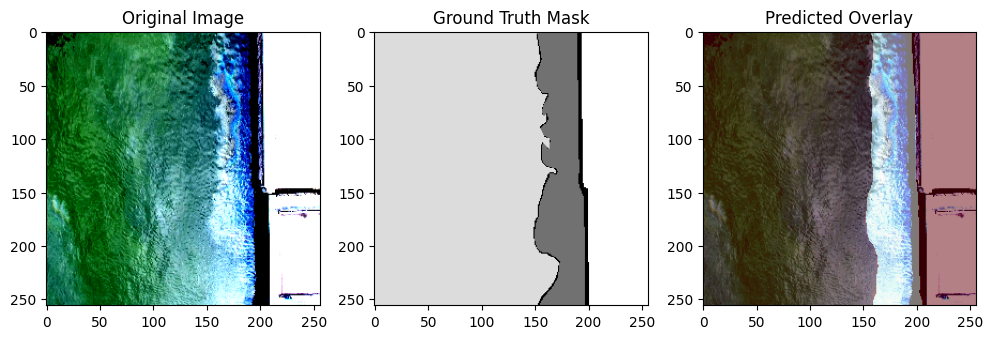

In [12]:
# Load best model
model.load_state_dict(torch.load("deeplabv3_oilspill.pth", map_location=device))
model.eval()

# Pick sample from validation
img, mask = val_dataset[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)["out"]
    pred = torch.sigmoid(output).cpu().squeeze().numpy() > 0.5

# Overlay
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img.cpu().squeeze().permute(1,2,0))
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(img.cpu().squeeze().permute(1,2,0))
plt.imshow(pred, cmap="Reds", alpha=0.5)  # overlay
plt.title("Predicted Overlay")
plt.show()


this code loads  best-trained DeepLabv3+ model, picks one validation image, generates a predicted segmentation mask, and shows: original image, ground truth mask, and prediction overlay (oil spill in red).

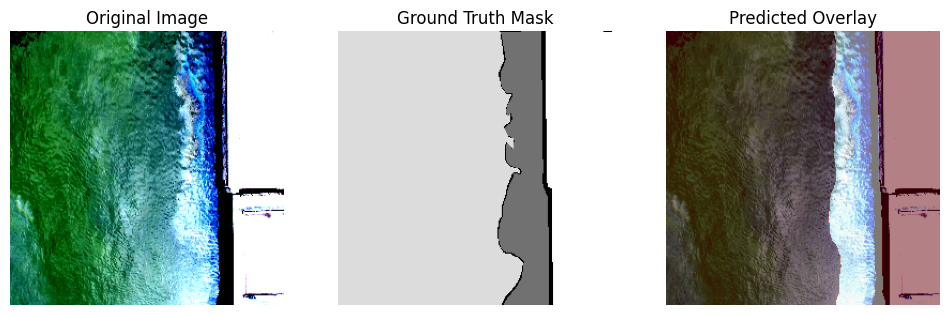

In [15]:
import matplotlib.pyplot as plt
import torch

# Make sure model is in evaluation mode
model.eval()

# Pick a sample from validation dataset
img, mask = val_dataset[0]  # get first image-mask pair

# Add batch dimension and move to device
img_batch = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img_batch)["out"]  # forward pass
    pred_mask = torch.sigmoid(output).cpu().squeeze()  # remove batch dim
    pred_mask = (pred_mask > 0.5).numpy()  # threshold to binary mask

# Convert mask to numpy
mask_np = mask.numpy()

# Plot original image, ground truth, and overlay
plt.figure(figsize=(12,4))

# Original image
plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))  # C,H,W -> H,W,C
plt.title("Original Image")
plt.axis("off")

# Ground truth mask
plt.subplot(1,3,2)
plt.imshow(mask_np.squeeze(), cmap="gray")  # remove channel dim if exists
plt.title("Ground Truth Mask")
plt.axis("off")

# Predicted overlay
plt.subplot(1,3,3)
plt.imshow(img.permute(1,2,0))
plt.imshow(pred_mask, cmap="Reds", alpha=0.5)  # overlay mask
plt.title("Predicted Overlay")
plt.axis("off")

plt.show()


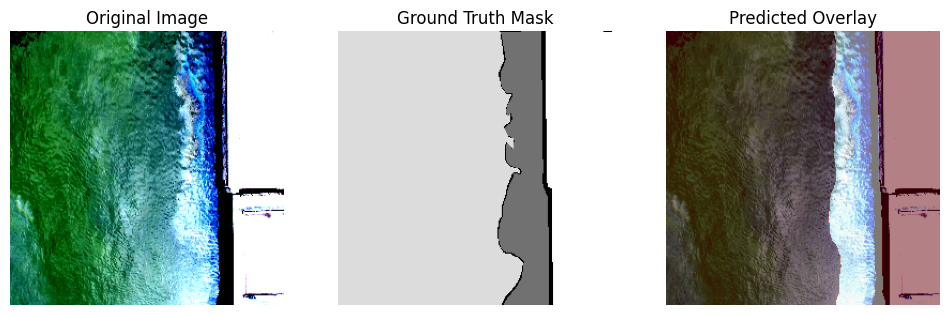

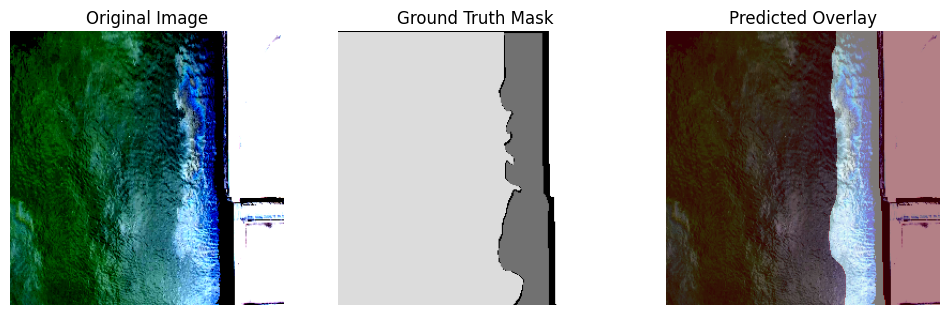

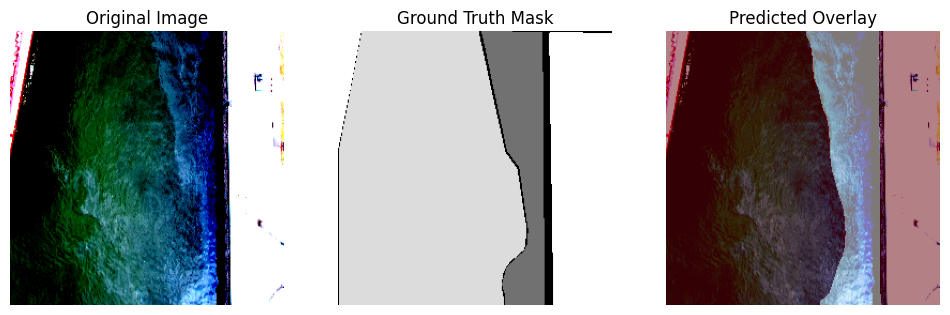

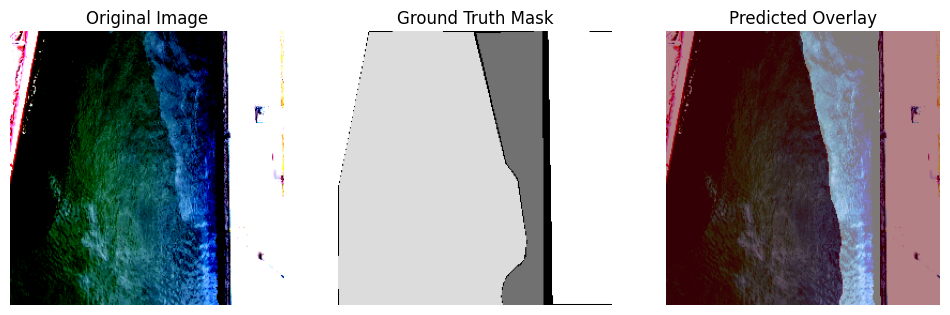

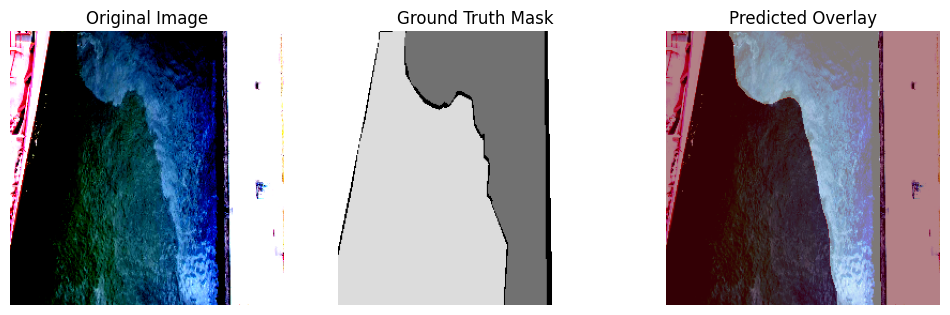

In [17]:
import matplotlib.pyplot as plt
import torch

model.eval()  # evaluation mode

num_samples = 5  # number of samples to visualize

for i in range(num_samples):
    img, mask = val_dataset[i]
    img_batch = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_batch)["out"]
        pred_mask = torch.sigmoid(output).cpu().squeeze()
        pred_mask = (pred_mask > 0.5).numpy()

    mask_np = mask.numpy()

    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Original Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1,3,2)
    plt.imshow(mask_np.squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted overlay
    plt.subplot(1,3,3)
    plt.imshow(img.permute(1,2,0))
    plt.imshow(pred_mask, cmap="Reds", alpha=0.5)
    plt.title("Predicted Overlay")
    plt.axis("off")

    plt.show()


In [18]:
import shutil

# Move your model to /kaggle/working/ if not already there
shutil.move("deeplabv3_oilspill.pth", "/kaggle/working/deeplabv3_oilspill.pth")


'/kaggle/working/deeplabv3_oilspill.pth'